<a href="https://colab.research.google.com/github/miNts3524/Bioinformatics/blob/main/Af_validation_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%time
#@title setup **RFdiffusion** (~3min)
from google.colab import drive
drive.mount('/content/drive')



import os, time, signal
import sys, random, string, re
if not os.path.isdir("params"):
  os.system("apt-get install aria2")
  os.system("mkdir params")
  # send param download into background
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")

"""
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/f572d396fae9206628714fb2ce00f72e/Complex_beta_ckpt.pt; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")
"""

if not os.path.isdir("RFdiffusion"):
  print("installing RFdiffusion...")
  os.system("git clone https://github.com/sokrypton/RFdiffusion.git")
  os.system("pip install jedi omegaconf hydra-core icecream pyrsistent pynvml decorator")
  os.system("pip install git+https://github.com/NVIDIA/dllogger#egg=dllogger")
  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  os.system("pip install --no-dependencies dgl==2.0.0 -f https://data.dgl.ai/wheels/cu121/repo.html")
  os.system("pip install --no-dependencies e3nn==0.3.3 opt_einsum_fx")
  os.system("cd RFdiffusion/env/SE3Transformer; pip install .")
  os.system("wget -qnc https://files.ipd.uw.edu/krypton/ananas")
  os.system("chmod +x ananas")

if not os.path.isdir("colabdesign"):
  print("installing ColabDesign...")
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

if not os.path.isdir("RFdiffusion/models"):
  print("downloading RFdiffusion params...")
  os.system("mkdir RFdiffusion/models")
  models = ["Base_ckpt.pt","Complex_base_ckpt.pt","Complex_beta_ckpt.pt"]
  for m in models:
    while os.path.isfile(f"{m}.aria2"):
      time.sleep(5)
  os.system(f"mv {' '.join(models)} RFdiffusion/models")
  os.system("unzip schedules.zip; rm schedules.zip")

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

# def run_ananas(pdb_str, path, sym=None):
#   pdb_filename = f"outputs/{path}/ananas_input.pdb"
#   out_filename = f"outputs/{path}/ananas.json"
#   with open(pdb_filename,"w") as handle:
#     handle.write(pdb_str)

#   cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
#   if sym is None: os.system(cmd)
#   else: os.system(f"{cmd} {sym}")

#   # parse results
#   try:
#     out = json.loads(open(out_filename,"r").read())
#     results,AU = out[0], out[-1]["AU"]
#     group = AU["group"]
#     chains = AU["chain names"]
#     rmsd = results["Average_RMSD"]
#     print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

#     C = np.array(results['transforms'][0]['CENTER'])
#     A = [np.array(t["AXIS"]) for t in results['transforms']]

#     # apply symmetry and filter to the asymmetric unit
#     new_lines = []
#     for line in pdb_str.split("\n"):
#       if line.startswith("ATOM"):
#         chain = line[21:22]
#         if chain in chains:
#           x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
#           if group[0] == "c":
#             x = sym_it(x,C,A[0])
#           if group[0] == "d":
#             x = sym_it(x,C,A[1],A[0])
#           coord_str = "".join(["{:8.3f}".format(a) for a in x])
#           new_lines.append(line[:30]+coord_str+line[54:])
#       else:
#         new_lines.append(line)
#     return results, "\n".join(new_lines)

#   except:
#     return None, pdb_str

# def run(command, steps, num_designs=1, visual="none"):

#   def run_command_and_get_pid(command):
#     pid_file = '/dev/shm/pid'
#     os.system(f'nohup {command} & echo $! > {pid_file}')
#     with open(pid_file, 'r') as f:
#       pid = int(f.read().strip())
#     os.remove(pid_file)
#     return pid
#   def is_process_running(pid):
#     try:
#       os.kill(pid, 0)
#     except OSError:
#       return False
#     else:
#       return True

#   run_output = widgets.Output()
#   progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
#   display(widgets.VBox([progress, run_output]))

#   # clear previous run
#   for n in range(steps):
#     if os.path.isfile(f"/dev/shm/{n}.pdb"):
#       os.remove(f"/dev/shm/{n}.pdb")

#   pid = run_command_and_get_pid(command)
#   try:
#     fail = False
#     for _ in range(num_designs):

#       # for each step check if output generated
#       for n in range(steps):
#         wait = True
#         while wait and not fail:
#           time.sleep(0.1)
#           if os.path.isfile(f"/dev/shm/{n}.pdb"):
#             pdb_str = open(f"/dev/shm/{n}.pdb").read()
#             if pdb_str[-3:] == "TER":
#               wait = False
#             elif not is_process_running(pid):
#               fail = True
#           elif not is_process_running(pid):
#             fail = True

#         if fail:
#           progress.bar_style = 'danger'
#           progress.description = "failed"
#           break

#         else:
#           progress.value = (n+1) / steps
#           if visual != "none":
#             with run_output:
#               run_output.clear_output(wait=True)
#               if visual == "image":
#                 xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
#                 fig = plt.figure()
#                 fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
#                 ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
#                 plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
#                 plt.show()
#               if visual == "interactive":
#                 view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
#                 view.addModel(pdb_str,'pdb')
#                 view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
#                 view.zoomTo()
#                 view.show()
#         if os.path.exists(f"/dev/shm/{n}.pdb"):
#           os.remove(f"/dev/shm/{n}.pdb")
#       if fail:
#         progress.bar_style = 'danger'
#         progress.description = "failed"
#         break

#     while is_process_running(pid):
#       time.sleep(0.1)

#   except KeyboardInterrupt:
#     os.kill(pid, signal.SIGTERM)
#     progress.bar_style = 'danger'
#     progress.description = "stopped"

# def run_diffusion(contigs, path, pdb=None, iterations=50,
#                   symmetry="none", order=1, hotspot=None,
#                   chains=None, add_potential=False, partial_T="auto",
#                   num_designs=1, use_beta_model=False, visual="none"):

#   full_path = f"outputs/{path}"
#   os.makedirs(full_path, exist_ok=True)
#   opts = [f"inference.output_prefix={full_path}",
#           f"inference.num_designs={num_designs}"]

#   if chains == "": chains = None

#   # determine symmetry type
#   if symmetry in ["auto","cyclic","dihedral"]:
#     if symmetry == "auto":
#       sym, copies = None, 1
#     else:
#       sym, copies = {"cyclic":(f"c{order}",order),
#                      "dihedral":(f"d{order}",order*2)}[symmetry]
#   else:
#     symmetry = None
#     sym, copies = None, 1

#   # determine mode
#   contigs = contigs.replace(","," ").replace(":"," ").split()
#   is_fixed, is_free = False, False
#   fixed_chains = []
#   for contig in contigs:
#     for x in contig.split("/"):
#       a = x.split("-")[0]
#       if a[0].isalpha():
#         is_fixed = True
#         if a[0] not in fixed_chains:
#           fixed_chains.append(a[0])
#       if a.isnumeric():
#         is_free = True
#   if len(contigs) == 0 or not is_free:
#     mode = "partial"
#   elif is_fixed:
#     mode = "fixed"
#   else:
#     mode = "free"

#   # fix input contigs
#   if mode in ["partial","fixed"]:
#     pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
#     if symmetry == "auto":
#       a, pdb_str = run_ananas(pdb_str, path)
#       if a is None:
#         print(f'ERROR: no symmetry detected')
#         symmetry = None
#         sym, copies = None, 1
#       else:
#         if a["group"][0] == "c":
#           symmetry = "cyclic"
#           sym, copies = a["group"], int(a["group"][1:])
#         elif a["group"][0] == "d":
#           symmetry = "dihedral"
#           sym, copies = a["group"], 2 * int(a["group"][1:])
#         else:
#           print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
#           symmetry = None
#           sym, copies = None, 1

#     elif mode == "fixed":
#       pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

#     pdb_filename = f"{full_path}/input.pdb"
#     with open(pdb_filename, "w") as handle:
#       handle.write(pdb_str)

#     parsed_pdb = parse_pdb(pdb_filename)
#     opts.append(f"inference.input_pdb={pdb_filename}")
#     if mode in ["partial"]:
#       if partial_T == "auto":
#         iterations = int(80 * (iterations / 200))
#       else:
#         iterations = int(partial_T)
#       opts.append(f"diffuser.partial_T={iterations}")
#       contigs = fix_partial_contigs(contigs, parsed_pdb)
#     else:
#       opts.append(f"diffuser.T={iterations}")
#       contigs = fix_contigs(contigs, parsed_pdb)
#   else:
#     opts.append(f"diffuser.T={iterations}")
#     parsed_pdb = None
#     contigs = fix_contigs(contigs, parsed_pdb)

#   if hotspot is not None and hotspot != "":
#     hotspot = ",".join(hotspot.replace(","," ").split())
#     opts.append(f"ppi.hotspot_res='[{hotspot}]'")

#   # setup symmetry
#   if sym is not None:
#     sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
#     if add_potential:
#       sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
#                    "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
#                    "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
#     opts = sym_opts + opts
#     contigs = sum([contigs] * copies,[])

#   opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
#   opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
#   if use_beta_model:
#     opts += ["inference.ckpt_override_path=./RFdiffusion/models/Complex_beta_ckpt.pt"]

#   print("mode:", mode)
#   print("output:", full_path)
#   print("contigs:", contigs)

#   opts_str = " ".join(opts)
#   cmd = f"./RFdiffusion/run_inference.py {opts_str}"
#   print(cmd)

#   # RUN
#   #run(cmd, iterations, num_designs, visual=visual)

#   # fix pdbs
#   # for n in range(num_designs):
#   #   pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
#   #           f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
#   #           f"{full_path}_{n}.pdb"]
#   #   for pdb in pdbs:
#   #     with open(pdb,"r") as handle: pdb_str = handle.read()
#   #     with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))
#   print(contigs, copies)
#   return contigs, copies

from string import ascii_uppercase, ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)
import os

from Bio.PDB import PDBParser, Polypeptide

def get_info(contig):
  F = []
  free_chain = False
  fixed_chain = False
  sub_contigs = [x.split("-") for x in contig.split("/")]
  for n,(a,b) in enumerate(sub_contigs):
    if a[0].isalpha():
      L = int(b)-int(a[1:]) + 1
      F += [1] * L
      fixed_chain = True
    else:
      L = int(b)
      F += [0] * L
      free_chain = True
  return F,[fixed_chain,free_chain]



def three_to_one(aa):
    """3-letter 아미노산 코드를 1-letter 코드로 변환"""
    aa_three_to_one = {
        'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
        'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
        'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
        'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V',
        'SEC': 'U', 'PYL': 'O', 'ASX': 'B', 'GLX': 'Z', 'XLE': 'J',
        'XAA': 'X', 'UNK': 'X'
    }
    return aa_three_to_one.get(aa, 'X')

class PDBInfo:
    def __init__(self, pdb_file_path, target_chain_ids):
        self.pdb_file_path = pdb_file_path
        self.target_chain_ids = target_chain_ids
        self.chain_info = self._parse_pdb(pdb_file_path)
        self.prep_flags, self.protocol = self._generate_prep_flags()

    def _parse_pdb(self, pdb_file_path):
        """PDB 파일을 파싱하고 체인 정보를 추출"""
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("protein", pdb_file_path)

        chain_info = {}

        for chain in structure[0]:
            chain_id = chain.id
            full_sequence = []
            sequence_parts = []
            current_segment = []
            previous_residue_id = None
            for residue in chain:
                if Polypeptide.is_aa(residue, standard=True):
                    current_residue_id = residue.id[1]
                    full_sequence.append(three_to_one(residue.resname))

                    if previous_residue_id is None or current_residue_id == previous_residue_id + 1:
                        current_segment.append(current_residue_id)
                    else:
                        if current_segment:
                            sequence_parts.append((current_segment[0], current_segment[-1]))
                        current_segment = [current_residue_id]

                    previous_residue_id = current_residue_id

            if current_segment:
                sequence_parts.append((current_segment[0], current_segment[-1]))

            summary = "/".join([f"{start}-{end}" for start, end in sequence_parts])
            chain_info[chain_id] = {
                "chain_id": chain_id,
                "chain_seq": "".join(full_sequence),
                "summary": summary,
                "length": len(full_sequence)
            }

        return chain_info

    def _generate_prep_flags(self):
        """PDB 파일에 대한 준비 플래그를 생성"""

        contig_str = ":".join(self.get_contigs())
        contigs = []
        for contig_str in contig_str.replace(" ", ":").replace(",", ":").split(":"):
            if len(contig_str) > 0:
                contig = []
                for x in contig_str.split("/"):
                    if x != "0": contig.append(x)
                contigs.append("/".join(contig))

        chains = alphabet_list[:len(contigs)]
        info = [get_info(x) for x in contigs]
        fixed_pos = []
        fixed_chains = []
        free_chains = []
        both_chains = []
        for pos, (fixed_chain, free_chain) in info:
            fixed_pos += pos
            fixed_chains += [fixed_chain and not free_chain]
            free_chains += [free_chain and not fixed_chain]
            both_chains += [fixed_chain and free_chain]

        if sum(both_chains) == 0 and sum(fixed_chains) > 0 and sum(free_chains) > 0 :
            protocol = "binder"
            target_chains = []
            binder_chains = []
            for n,x in enumerate(fixed_chains):
                if x: target_chains.append(chains[n])
                else: binder_chains.append(chains[n])
            prep_flags = {"target_chain": ",".join(target_chains),
                          "binder_chain": ",".join(binder_chains),
                          "rm_aa": 'None'}
        return prep_flags, protocol


    def target_info(self):
        """타겟 체인 정보를 반환"""
        return {
            "pdb_path": self.pdb_file_path,
            "chains": {cid: self.chain_info[cid] for cid in self.target_chain_ids if cid in self.chain_info}
        }

    def chain(self, chain_id):
        """특정 체인의 정보를 반환"""
        return self.chain_info.get(chain_id, None)

    def all_chains(self):
        """모든 체인의 정보를 반환"""
        return self.chain_info

    def all_sequences(self):
        """모든 체인의 서열을 '/'로 구분하여 하나의 문자열로 반환"""
        return "/".join([self.chain_info[chain_id]["chain_seq"] for chain_id in self.chain_info])

    def get_contigs(self):
        """target 체인에 대한 contigs를 반환"""
        contigs = []

        # binder (A 체인)의 길이를 추가
        binder_info = self.chain_info.get('A')
        if binder_info:
            binder_length = binder_info["length"]
            contigs.append(f"{binder_length}-{binder_length}")

        for chain_id in self.target_chain_ids:
            chain_info = self.chain_info.get(chain_id)
            if chain_info:
                summary = chain_info["summary"]
                parts = summary.split("/")
                contig_parts = [f"{chain_id}{part}" for part in parts]
                contigs.append("/".join(contig_parts))
        return contigs
    def get_prep_flags(self):
        return self.prep_flags


class PDBManager:
    def __init__(self, input_dir, target_chain_ids):
        self.input_dir = input_dir
        self.target_chain_ids = target_chain_ids
        self.pdb_info_list = self._load_pdb_files()

    def _load_pdb_files(self):
        pdb_info_list = []
        pdb_files = [os.path.join(self.input_dir, f) for f in os.listdir(self.input_dir) if f.endswith(".pdb")]
        print(f"Found PDB files: {pdb_files}")  # 디버깅을 위해 추가
        for pdb_file in pdb_files:
            print(f"Processing PDB file: {pdb_file}")  # 디버깅을 위해 추가
            pdb_info = PDBInfo(pdb_file, self.target_chain_ids)
            pdb_info_list.append(pdb_info)
        return pdb_info_list

    def get_pdb_info(self, pdb_file_path):
        for pdb_info in self.pdb_info_list:
            if pdb_info.pdb_file_path == pdb_file_path:
                return pdb_info
        return None

    def get_all_pdbs(self):
        return self.pdb_info_list

Mounted at /content/drive
installing RFdiffusion...
installing ColabDesign...
downloading RFdiffusion params...
CPU times: user 6.33 s, sys: 1.08 s, total: 7.41 s
Wall time: 2min 48s


In [ ]:
#@title Install AF
import os,sys
from colabdesign.af import mk_af_model
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.parse_args import parse_args

import pandas as pd
import numpy as np
from google.colab import data_table
data_table.enable_dataframe_formatter()

def designable(target_chain_list, arg_rm_aa, arg_copies, arg_initial_guess, arg_use_multimer, arg_num_seqs, arg_num_recycles, input_dir):
    pdb_manager = PDBManager(input_dir, target_chain_list)

    flags = {"initial_guess": arg_initial_guess,
                "best_metric": "rmsd",
                "use_multimer": arg_use_multimer,
                "model_names": ["model_1_multimer_v3" if arg_use_multimer else "model_1_ptm"]}

    ###################################need to fix#####################################################
    protocol = 'binder'
    af_model = mk_af_model(protocol, **flags)
    #####################Running AF#####################
    if protocol == "binder":
        af_terms = ["plddt","i_ptm","i_pae","rmsd"]
    elif arg_copies > 1:
        af_terms = ["plddt","ptm","i_ptm","pae","i_pae","rmsd"]
    else:
        af_terms = ["plddt","ptm","pae","rmsd"]


    labels = ["design","n","score"] + af_terms + ["seq"]

    print("running AlphaFold...")


    output_dir = f"{input_dir}/Af_validation"
    os.system(f"mkdir -p {output_dir}/all_pdb")

    #os.system(f"mkdir -p {output_dir}")

    outs = []
    pdbs = pdb_manager.get_all_pdbs()
    filtered = []
    data = []
    binder = {"data_binder" : [], "binder_path" : [], "binder_input" : []}
    with open(f"{output_dir}/design.fasta","w") as fasta:
        count = 1
        for m, pdb in enumerate(pdbs):
            out = {"design": [], "n": [], "score": [], "seq": []}
            pdb_path = pdb.pdb_file_path
            total_sequence = pdb.all_sequences()
            prep_flags = pdb.get_prep_flags()
            prep_flags["rm_aa"] = arg_rm_aa

            ###########################get_seqs.
            if protocol == 'binder':

                binder_sequence = pdb.chain_info['A']['chain_seq']
            else:
                error_message = "Not binder protocol"
                raise ValueError(error_message)

            for k in af_terms:
              out[k] = []
            #for n in range(arg_num_seqs):
            af_model.prep_inputs(pdb.pdb_file_path, **prep_flags)
            out["design"] = m
            out["score"] = 0
            out["seq"] = total_sequence

            #sub_seq = out["seq"].replace("/","")[af_model._len:]

            sub_seq = binder_sequence
            af_model.predict(seq=sub_seq, num_recycles=arg_num_recycles, verbose=False)
            for t in af_terms:
                out[t] = af_model.aux["log"][t]
            for t in af_terms:
                out[t] = af_model.aux["log"][t]
            if "i_pae" in out:
                out["i_pae"] = out["i_pae"] * 31
            if "pae" in out:
                out["pae"] = out["pae"] * 31
            rmsd = out["rmsd"]


            # Get binder
            if out["i_pae"] < 10 and out["rmsd"] < 1 and out["plddt"] > 0.8:
                print("Congraturations!! Binder was Found!!! ⤵⤵⤵")
                af_model.save_current_pdb(f"{output_dir}/binder_{m}.pdb")
                binder["data_binder"].append([out[k] for k in labels])
                binder["binder_path"].append(f"{output_dir}/binder_{m}.pdb")
                binder["binder_input"].append(f"{pdb.pdb_file_path}")

            af_model.save_current_pdb(f"{output_dir}/all_pdb/design_{m}.pdb")
            af_model._save_results(save_best=True, verbose=False)
            af_model._k += 1
            score_line = [f'design : {m}']
            for t in af_terms:
                score_line.append(f'{t} : {out[t]:.3f}')
            line = f'>{"|".join(score_line)}\n{out["seq"]}'
            fasta.write(line+"\n")
            outs.append(out)
            #print(" ".join(score_line)+" "+out["seq"])
            data.append([out[k] for k in labels])
            print(f"Design : {m}, plddt : {out['plddt']:.3f}, rmsd : {out['rmsd']:.3f}, i_pae : {out['i_pae']:.3f}")
            print(f"Sequence : {out['seq']}")


    df = pd.DataFrame(data, columns = labels)
    df.to_csv(f'{output_dir}/AF_valid.csv')
    df_binder = pd.DataFrame(binder['data_binder'], columns = labels)
    df_binder.to_csv(f'{output_dir}/AF_binder.csv')
    data_table.DataTable(df.sort_values("rmsd").round(3))
    #print(df.sort_values("rmsd").round(3))

    return binder, df , labels


In [ ]:
%%time
#@title run **AlphaFold** to validate


#drive/MyDrive/pdb_files/hotspot_mpnn_step2

#@markdown INPUT directory -- drive/MyDrive
input_dir = "drive/MyDrive/pdb_files/total_hotspot" #@param {type:"string"}
#output_dir = 'drive/MyDrive/pdb_files/hotpot' #@param {type:"string"}

#@markdown ProteinMPNN Settings

Target_chain = 'B' #@param {type:"string"}
target_chain_list = Target_chain.split(",")
print(target_chain_list)

num_seqs = 1 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
#mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C" #@param {type:"string"}
use_solubleMPNN = False #@param {type:"boolean"}
#@markdown - `Target_chain` - list chains. (ex. A,B) / caution **No space**
#@markdown - `mpnn_sampling_temp` - control diversity of sampled sequences. (higher = more diverse).
#@markdown - `rm_aa='C'` - do not use [C]ysteines.
#@markdown - `use_solubleMPNN` - use weights trained only on soluble proteins. See [preprint](https://www.biorxiv.org/content/10.1101/2023.05.09.540044v2).
#@markdown
#@markdown AlphaFold Settings
initial_guess = True #@param {type:"boolean"}
#@markdown - soft initialization with desired coordinates, see [paper](https://www.nature.com/articles/s41467-023-38328-5).
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
#@markdown - for **binder** design, we recommend `initial_guess=True num_recycles=3`
use_multimer = True #@param {type:"boolean"}
#@markdown - `use_multimer` - use AlphaFold Multimer v3 params for prediction.


#Getting PDB
# for pdb_info in pdb_manager.get_all_pdbs():
#     print(f"PDB Path: {pdb_info.pdb_file_path}")
#     print("Target Chains:")
#     for chain_id, details in pdb_info.target_info()["chains"].items():
#         print(f"  Chain ID: {details['chain_id']}")
#         print(f"  Chain Sequence: {details['chain_seq']}")
#         print(f"  Summary: {details['summary']}")
#     print("All Chains:")
#     for chain_id, details in pdb_info.all_chains().items():
#         print(f"  Chain ID: {details['chain_id']}")
#         print(f"  Chain Sequence: {details['chain_seq']}")
#         print(f"  Summary: {details['summary']}")
#     print(f"All Sequences: {pdb_info.all_sequences()}")
#     print("Contigs: ", pdb_info.get_contigs())
#     print("Prep Flags: ", pdb_info.get_prep_flags())
#     print()


# output_folder = os.path.join(input_dir, "AF_all_pdb")

# #pdb_list = [os.path.join(input_dir,x) for x in os.listdir(input_dir) if x.endswith(".pdb")]
# target_chain_list = Target_chain.split(",")
# #print(target_chain_list)




copies = 1 #binder

binder, df, labels = designable(target_chain_list,
                    rm_aa,
                    copies,
                    initial_guess,
                    use_multimer,
                    num_seqs,
                    num_recycles,
                    input_dir)


# result_df = pd.DataFrame(binder['data_binder'], columns=labels)
# print(result_df)
# data_table.DataTable(result_df.sort_values("rmsd").round(3))


['B']
Found PDB files: ['drive/MyDrive/pdb_files/total_hotspot/protein_3_dldesign_1_dldesign_0_cycle3_3.pdb', 'drive/MyDrive/pdb_files/total_hotspot/protein_3_dldesign_1_dldesign_0_cycle3.pdb', 'drive/MyDrive/pdb_files/total_hotspot/protein_3_dldesign_1_dldesign_0_cycle3_2.pdb', 'drive/MyDrive/pdb_files/total_hotspot/protein_10_dldesign_1_dldesign_0_cycle3_2.pdb', 'drive/MyDrive/pdb_files/total_hotspot/protein_10_dldesign_1_dldesign_0_cycle3_3.pdb', 'drive/MyDrive/pdb_files/total_hotspot/protein_10_dldesign_1_dldesign_0_cycle3.pdb', 'drive/MyDrive/pdb_files/total_hotspot/protein_18_dldesign_0_dldesign_0_cycle3_3.pdb', 'drive/MyDrive/pdb_files/total_hotspot/protein_18_dldesign_1_dldesign_0_cycle3_3.pdb', 'drive/MyDrive/pdb_files/total_hotspot/protein_18_dldesign_0_dldesign_0_cycle3_2.pdb', 'drive/MyDrive/pdb_files/total_hotspot/protein_18_dldesign_0_dldesign_0_cycle3.pdb', 'drive/MyDrive/pdb_files/total_hotspot/protein_10_dldesign_0_dldesign_0_cycle3_3.pdb', 'drive/MyDrive/pdb_files/tot

In [ ]:
#@title Total result summary : table

df_total =pd.DataFrame(df, columns=labels)
df_total = df_total.drop(['n', 'design','score'], axis = 'columns')
data_table.DataTable(df_total.sort_values("rmsd").round(3))

,plddt,i_ptm,i_pae,rmsd,seq
1,0.905,0.809,4.972,0.174,SAAKTAEIIAELDKLLEEGKILELLKKILELVKDPNITDEVIAKIV...
0,0.903,0.818,4.688,0.216,SAALRALVEQLLVYALTFRDDPAVRERIRAELLRHPAVTPEQAEAA...


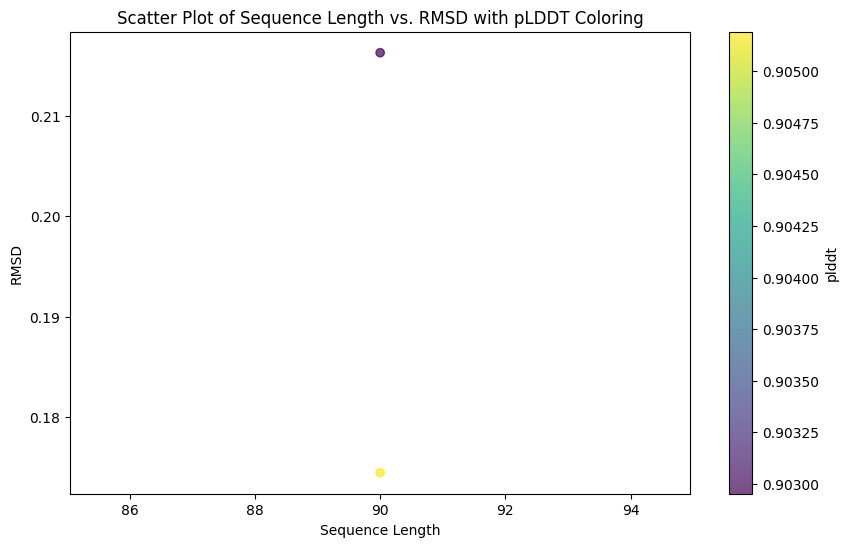

In [ ]:
#@title Total result summary : table

df_total['binder_length'] =df['seq'].apply(lambda x: len(x.split("/")[0]))
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_total['binder_length'],
                      df_total['rmsd'],
                      c=df_total['plddt'],
                      cmap='viridis',
                      alpha=0.7)

plt.colorbar(scatter, label='plddt')
plt.xlabel('Sequence Length')
plt.ylabel('RMSD')
plt.title('Scatter Plot of Sequence Length vs. RMSD with pLDDT Coloring')
plt.show()

In [ ]:
#@title Display Binder result
import py3Dmol

def plot_pdb(binder, binder_input):
  with open(binder,"r") as f:
    # REMARK 001 design {m} N {n} RMSD {rmsd}
    #info = f.readline().strip('\n').split()
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    pdb_str = open(binder_input,'r').read()
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    pdb_str = open(binder,'r').read()
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

    view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
    view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
    view.zoomTo()
    view.show()

                # binder["data_binder"].append([out[k] for k in labels])
                # binder["binder_path"].append(f"{output_dir}/Af_validation/binder_{m}.pdb")
                # binder["binder_input"].append(f"{pdb.pdb_file_path}")


# if len(binder["binder_path"]) < 1:
#   print("Binder was not found!")

# if len(binder) > 1:
#   print(f"{len(binder['binder_path'])} binder was found!")
#   output = widgets.Output()
#   def on_change(change):
#     if change['name'] == 'value':
#       with output:
#         output.clear_output(wait=True)
#         plot_pdb(change['new'])
#   dropdown = widgets.Dropdown(
#       options=[(f'{k}',k) for k in range(len(binder['binder_path']))],
#       value=0, description='design:',
#   )
#   dropdown.observe(on_change)
#   display(widgets.VBox([dropdown, output]))
#   with output:
#     plot_pdb(dropdown.value)
# else:
#   plot_pdb()
if len(binder["binder_path"]) < 1:
    print("Binder was not found!")
else:
    if len(binder["binder_path"]) > 1:
        print(f"{len(binder['binder_path'])} binders were found!")
        output = widgets.Output()

        def on_change(change):
            if change['name'] == 'value':
                with output:
                    output.clear_output(wait=True)
                    plot_pdb(binder['binder_path'][change['new']], binder['binder_input'][change['new']])

        dropdown = widgets.Dropdown(
            options=[(f'{k}', k) for k in range(len(binder['binder_path']))],
            value=0, description='design:'
        )
        dropdown.observe(on_change, names='value')
        display(widgets.VBox([dropdown, output]))

        with output:
            plot_pdb(binder['binder_path'][0], binder['binder_input'][0])
    else:
        plot_pdb(binder['binder_path'][0], binder['binder_input'][0])


2 binders were found!
